# Reversal Trading Using Correlated Triples

We seek triples of coins such that the behavior of one is modeled well by a function of the other two based on a linear regression model. We explore four combinations of two different variants of two distinct paradigms, listed below:

1. Indicator variables and dependent variables to use - large price movements can add noise so we explore use of linear regression models with the following inputs and outputs:
    - Inputs: prices of two coins, output: price of a third coin
    - Inputs: log prices of two coins, output: log price of a third coin
2. Selection of correlated coins - if two coins are highly correlated with a third coin, selecting them both as independent predictors of the third coin may be redundant so we also consider selecting independent coins which have the least correlation with the dependent coin (above a certain threshold):
    - Above a certain threshold, for a given dependent coin, choose the highest correlated coins available as its predictors
    - Above a certain threshold, for a given dependent coin, choose the lowest correlated coins available as its predictors.

Regarding (2) above, one other possible approach worth exploring which is not explored in this notebook would be to pick the independent variables to not be highly correlated with each other rather than to the dependent coin.

Using predictive models in these cases, when we observe a deviation in the dependent variable from what is predicted by our model, we predict reversal and long the under-priced asset(s) and short the over-priced asset(s). We dynamically re-select triples of correlated coins in a given look-back window. We test different parameters for selecting coins on the in-sample data and report the results for the out-sample data.

Regarding the first variant of (1), in the best case, when using prices as independent and dependent variables, the in-sample Sharpe Ratio (over the period from 2020-01-01 00:00:00 to 2022-12-31 20:00:00) is 0.26 with a corresponding out-sample Sharpe Ratio (over the period from 2023-01-01 00:00:00 to 2025-02-20 08:00:00) of 1.53, when using the lowest correlated coins to select.

Regarding the second variant of (1), in the best case, when using log prices as independent and dependent variables, the in-sample Sharpe Ratio is 0.356 and the out-sample Sharpe Ratio is 1.45.

# Coin Universe

We use a historical snapshot of coins from [December 01, 2019](https://coinmarketcap.com/historical/20191201/) to get a representative set of coins from before the period of analysis to avoid look-ahead bias.

In [2]:
strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

# Load And Structure Data

We extract closing prices over the interval from 2020-01-01 00:00:00 to 2025-02-20 08:00:00 with a frequency of 4 hours.

In [3]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_datetime, end_datetime):
    bn_data = client.get_historical_klines(coin, freq, start_datetime, end_datetime)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_datetime, end_datetime):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(
                coin, freq, start_datetime, end_datetime).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
end_datetime = '2025-02-20 08:00:00'
out_sample_start_datetime = pd.to_datetime("2023-01-01 00:00:00")

In [5]:
px_data = get_price_data_for_universe(data_freq, start_datetime, end_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [6]:
px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)

px_close

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,0.19406,205.64,41.58,NaN,13.8159,0.04515,NaN,0.03308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,0.19358,205.61,41.67,NaN,13.7162,0.04509,NaN,0.03321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,0.19474,206.35,41.79,NaN,13.7270,0.04547,NaN,0.03361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19 16:00:00,96235.29,2709.46,2.66600,321.30,135.19,0.5836,651.2500,0.33390,NaN,0.75890,...,0.3119,0.1309,0.6902,0.02921,0.03003,0.04663,NaN,0.577,4.878,168.79
2025-02-19 20:00:00,96650.01,2715.33,2.74310,322.90,135.10,0.5836,654.3400,0.34200,NaN,0.77420,...,0.3118,0.1304,0.7158,0.02936,0.03005,0.04663,NaN,0.577,4.851,169.00
2025-02-20 00:00:00,97040.40,2743.25,2.71250,325.30,133.33,0.6427,654.7100,0.34070,NaN,0.78140,...,0.3225,0.1320,0.7221,0.02936,0.03005,0.04663,NaN,0.577,4.905,172.56


# Define Functions For Picking Coins And Setting Holdings

In [62]:
import numpy as np
import statsmodels.api as sm
from enum import Enum

class CorrSelectionMethod(Enum):
    MAX_CORR = 1
    MIN_CORR = 2

def get_newly_uncorrelated_keys(current_correlated_triples, price_indicator_window_df,
                                corr_matrix, correlation_rejection_threshold):
    newly_uncorrelated_keys = set()
    for key_coin in current_correlated_triples:
        value_coin_1 = current_correlated_triples[key_coin].columns[0]
        value_coin_2 = current_correlated_triples[key_coin].columns[1]
        triple_list = [key_coin, value_coin_1, value_coin_2]
        
        # if any of the coins do not have data (e.g. if the coin no longer exists)
        if price_indicator_window_df[triple_list].iloc[-1].isnull().any():
            newly_uncorrelated_keys.add(key_coin)
        elif ((corr_matrix.loc[key_coin, value_coin_1] < correlation_rejection_threshold or \
               corr_matrix.loc[key_coin, value_coin_2] < correlation_rejection_threshold)):
            newly_uncorrelated_keys.add(key_coin)
    return newly_uncorrelated_keys


def remove_uncorrelated_keys(newly_uncorrelated_keys, coins_in_a_triple, current_correlated_triples):
    for coin in newly_uncorrelated_keys:
        coins_in_a_triple.remove(coin)
        coins_in_a_triple.remove(current_correlated_triples[coin].columns[0])
        coins_in_a_triple.remove(current_correlated_triples[coin].columns[1])
        
        if coin in current_correlated_triples: # only the dependent coin will appears as a key
            del current_correlated_triples[coin]


def has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, price_indicator_window_df,
                                 correlation_acceptance_threshold):
    if np.isnan(price_indicator_window_df[coin]).any():
        return False
    num_available_coins = 0
    for other_coin, coin_corr in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].items():
        if (other_coin != coin and (other_coin not in coins_in_a_triple) and \
            (not np.isnan(price_indicator_window_df[other_coin]).any())):
            num_available_coins += 1
    return num_available_coins >= 2


def update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        price_indicator_window_df, correlation_acceptance_threshold):
    largest_corr = -1.0
    largest_corr_coin = None
    second_largest_corr = -1.0
    second_largest_corr_coin = None
    for other_coin, coin_corr in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].items():
        if np.isnan(price_indicator_window_df[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= largest_corr:
            second_largest_corr, largest_corr = largest_corr, corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin, largest_corr_coin = largest_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= second_largest_corr:
            second_largest_corr = corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin = other_coin
            
    # assumed that at least two coins meeting the threshold have been found
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(largest_corr_coin)
    coins_in_a_triple.add(second_largest_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(
        0.0, columns=[largest_corr_coin, second_largest_corr_coin, 'alpha', 'residual'], index=[])


def update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        price_indicator_window_df, correlation_acceptance_threshold):
    smallest_corr = 1.0
    smallest_corr_coin = None
    second_smallest_corr = 1.0
    second_smallest_corr_coin = None
    for other_coin, other_coin_value in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].items():
        if np.isnan(price_indicator_window_df[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= smallest_corr:
            second_smallest_corr, smallest_corr = smallest_corr, corr_matrix.loc[coin, other_coin]
            second_smallest_corr_coin, smallest_corr_coin = smallest_corr_coin, other_coin
        elif other_coin != coin and corr_Matrix.loc[coin, other_coin] <= second_smallest_corr:
            second_smallest_corr = corr_matrix.loc[coin, other_coin]
            second_smallest_corr_coin = other_coin
    
    # assumed that at least two coins meeting the threshold have been found
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(smallest_corr_coin)
    coins_in_a_triple.add(second_smallest_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(
        0.0, columns=[smallest_corr_coin, second_smallest_corr_coin, 'alpha', 'residual'], index=[])


def update_correlated_triples(current_correlated_triples, coins_in_a_triple, corr_matrix, 
                              price_indicator_window_df, correlation_acceptance_threshold,
                              corr_selection_method):
    for coin in list(price_indicator_window_df.columns):
        if (coin not in coins_in_a_triple) and \
            has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, price_indicator_window_df,
                                         correlation_acceptance_threshold):
            
            if (corr_selection_method == CorrSelectionMethod.MAX_CORR):
                update_correlated_coins_to_max_corr(
                    coin,
                    corr_matrix,
                    coins_in_a_triple,
                    current_correlated_triples,
                    price_indicator_window_df,
                    correlation_acceptance_threshold)
            elif (corr_selection_method == CorrSelectionMethod.MIN_CORR):
                update_correlated_coins_to_min_corr(
                    coin,
                    corr_matrix,
                    coins_in_a_triple,
                    current_correlated_triples,
                    price_indicator_window_df,
                    correlation_acceptance_threshold)


def set_time_holdings(holdings_df, time_index, price_indicator_window_df, current_correlated_triples,
                      min_data_points_to_transact, look_back_window_size, z_score_min_threshold,
                      z_score_max_threshold):
    for coin in current_correlated_triples:
        independent_coin_1 = current_correlated_triples[coin].columns[0]
        independent_coin_2 = current_correlated_triples[coin].columns[1]
        
        model = sm.OLS(
            price_indicator_window_df[coin].iloc[:-1],
            sm.add_constant(price_indicator_window_df[[independent_coin_1, independent_coin_2]].iloc[:-1])
        )
        
        result = model.fit()
        result_data = {
            independent_coin_1: result.params[independent_coin_1],
            independent_coin_2: result.params[independent_coin_2],
            'alpha': result.params['const']
        }
        
        estimate = model.predict(
            result.params,
            sm.add_constant(
                price_indicator_window_df[[independent_coin_1, independent_coin_2]]).iloc[-1]
        )
        result_data['residual'] = price_indicator_window_df[coin].iloc[-1] - estimate
        result_series = pd.Series(result_data)
        current_correlated_triples[coin].loc[time_index] = result_series
        
        if len(current_correlated_triples[coin]) >= min_data_points_to_transact:
            z_score_look_back_len = min(look_back_window_size, len(current_correlated_triples[coin]))
            look_back_coin_regression_data = current_correlated_triples[coin].iloc[(-z_score_look_back_len):]
            residual_mean = look_back_coin_regression_data['residual'].mean()
            residual_std = look_back_coin_regression_data['residual'].std()
            z_score = (result_data['residual'] - residual_mean) / residual_std
            
            if z_score_min_threshold <= z_score <= z_score_max_threshold:
                holdings_df.loc[time_index, coin] = -1.0
                holdings_df.loc[time_index, independent_coin_1] = result_data[independent_coin_1]
                holdings_df.loc[time_index, independent_coin_2] = result_data[independent_coin_2]
            elif -z_score_max_threshold <= z_score <= -z_score_min_threshold:
                holdings_df.loc[time_index, coin] = 1.0
                holdings_df.loc[time_index, independent_coin_1] = -result_data[independent_coin_1]
                holdings_df.loc[time_index, independent_coin_2] = -result_data[independent_coin_2]

    holdings_df.loc[time_index] = holdings_df.loc[time_index] / holdings_df.loc[time_index].abs().sum()


def get_holdings_df(
    price_indicator_df,
    look_back_min_periods,
    look_back_window_size,
    correlation_acceptance_threshold,
    correlation_rejection_threshold,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold,
    corr_selection_method):
    
    holdings_df = pd.DataFrame(0.0, columns=price_indicator_df.columns, index=price_indicator_df.index)
    
    current_correlated_triples = dict()
    coins_in_a_triple = set()
    
    for index in range(look_back_min_periods, len(holdings_df)):
        window_start = max(index-look_back_window_size, 0)
        
        # exclude the data from the current index itself to avoid having to shift forward strategy holdings
        # later when calculating returns to avoid look-ahead bias
        price_indicator_window_df = price_indicator_df.iloc[window_start:index]
        
        time_index = price_indicator_df.index[index]
        holdings_df.loc[time_index] = pd.Series(0.0, index=holdings_df.columns)
        
        corr_matrix = price_indicator_window_df.corr()
        
        newly_uncorrelated_keys = get_newly_uncorrelated_keys(
            current_correlated_triples,
            price_indicator_window_df,
            corr_matrix,
            correlation_rejection_threshold)
        
        # update coins_in_a_triple and current_correlated_triples in-place
        remove_uncorrelated_keys(newly_uncorrelated_keys, coins_in_a_triple, current_correlated_triples)

        update_correlated_triples(
            current_correlated_triples,
            coins_in_a_triple,
            corr_matrix,
            price_indicator_window_df,
            correlation_acceptance_threshold,
            corr_selection_method)
        
        set_time_holdings(
            holdings_df,
            time_index,
            price_indicator_window_df,
            current_correlated_triples,
            min_data_points_to_transact, look_back_window_size, z_score_min_threshold, z_score_max_threshold)

    return holdings_df

# Define Functions For Evaluation

In [63]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias or that
    # data does not depend on current time point
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

Calculate the sharpe ratio of the net returns for both the in-sample period and the out-sample period.

In [64]:
def get_sharpe_ratio_data(net_returns_ser):
    sr_data = dict()
    sr_data["total sr"] = net_returns_ser.mean() / net_returns_ser.std() * np.sqrt(365 * 6)
    
    out_sample_start = pd.to_datetime(out_sample_start_datetime)
    in_sample_end = out_sample_start - pd.Timedelta(hours=4)
    
    sr_data["in-sample sr"] = net_returns_ser.loc[:in_sample_end].mean() / net_returns_ser.loc[:in_sample_end].std() * np.sqrt(365 * 6)
    sr_data["out-sample sr"] = net_returns_ser.loc[out_sample_start:].mean() / net_returns_ser.loc[out_sample_start:].std() * np.sqrt(365 * 6)
    sr_series = pd.Series(sr_data)
    return sr_series

# Evaluate Different Sets Of Parameters With Prices As Indicators

We consider the following parameter variations:
  - (min z-score, max z-score): (1.0, 10.0), (1.5, 10.0), (2.0, 10.0), (2.5, 10.0), (3.0, 10.0)
  - (correlation acceptance threshold, correlation rejection threshold): (0.9, 0.8), (0.85, 0.70)
  - method for selection based on correlation: maximum correlation, minimum correlation (above a threshold)
  
The output from the warnings about the hardware that this notebook was run on is very large so we incrementally re-run the same cell repeatedly while collecting the outputs from each variation in a csv file.

In [65]:
selection_conditions = []

for z_score_threshold_pair in ((1.0, 10.0), (1.5, 10.0), (2.0, 10.0), (2.5, 10.0), (3.0, 10.0)):
    for correlation_threshold_pair in ((0.9, 0.8), (0.85, 0.70)):
        for corr_selection_method in (CorrSelectionMethod.MAX_CORR, CorrSelectionMethod.MIN_CORR):
            selection_conditions.append((z_score_threshold_pair, correlation_threshold_pair,
                                         corr_selection_method))
selection_conditions

[((1.0, 10.0), (0.9, 0.8), <CorrSelectionMethod.MAX_CORR: 1>),
 ((1.0, 10.0), (0.9, 0.8), <CorrSelectionMethod.MIN_CORR: 2>),
 ((1.0, 10.0), (0.85, 0.7), <CorrSelectionMethod.MAX_CORR: 1>),
 ((1.0, 10.0), (0.85, 0.7), <CorrSelectionMethod.MIN_CORR: 2>),
 ((1.5, 10.0), (0.9, 0.8), <CorrSelectionMethod.MAX_CORR: 1>),
 ((1.5, 10.0), (0.9, 0.8), <CorrSelectionMethod.MIN_CORR: 2>),
 ((1.5, 10.0), (0.85, 0.7), <CorrSelectionMethod.MAX_CORR: 1>),
 ((1.5, 10.0), (0.85, 0.7), <CorrSelectionMethod.MIN_CORR: 2>),
 ((2.0, 10.0), (0.9, 0.8), <CorrSelectionMethod.MAX_CORR: 1>),
 ((2.0, 10.0), (0.9, 0.8), <CorrSelectionMethod.MIN_CORR: 2>),
 ((2.0, 10.0), (0.85, 0.7), <CorrSelectionMethod.MAX_CORR: 1>),
 ((2.0, 10.0), (0.85, 0.7), <CorrSelectionMethod.MIN_CORR: 2>),
 ((2.5, 10.0), (0.9, 0.8), <CorrSelectionMethod.MAX_CORR: 1>),
 ((2.5, 10.0), (0.9, 0.8), <CorrSelectionMethod.MIN_CORR: 2>),
 ((2.5, 10.0), (0.85, 0.7), <CorrSelectionMethod.MAX_CORR: 1>),
 ((2.5, 10.0), (0.85, 0.7), <CorrSelectionMethod

In [66]:
selection_index = 1

In [61]:
z_score_min_threshold, z_score_max_threshold = selection_conditions[selection_index][0]
correlation_acceptance_threshold, correlation_rejection_threshold = selection_conditions[selection_index][1]
corr_selection_method = selection_conditions[selection_index][2]

min_data_points_to_transact = 10 * 6

holdings_df = get_holdings_df(
    px_close,
    look_back_min_periods,
    look_back_window_size,
    correlation_acceptance_threshold,
    correlation_rejection_threshold,
    min_data_points_to_transact,
    z_score_min_threshold,
    z_score_max_threshold,
    corr_selection_method)

net_returns_ser = get_net_return(holdings_df, px_close / px_close.shift() - 1)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

NameError: name 'smallest_cor' is not defined

In [46]:
net_returns_ser

datetime
2020-01-01 00:00:00    0.000000
2020-01-01 04:00:00    0.000000
2020-01-01 08:00:00    0.000000
2020-01-01 12:00:00    0.000000
2020-01-01 16:00:00    0.000000
                         ...   
2025-02-19 16:00:00   -0.002752
2025-02-19 20:00:00   -0.000220
2025-02-20 00:00:00    0.020142
2025-02-20 04:00:00   -0.002000
2025-02-20 08:00:00    0.009185
Length: 11259, dtype: float64

In [47]:
sharpe_ratio_ser

total sr        -0.645926
in-sample sr    -1.622978
out-sample sr    0.849643
dtype: float64

<Axes: xlabel='datetime'>

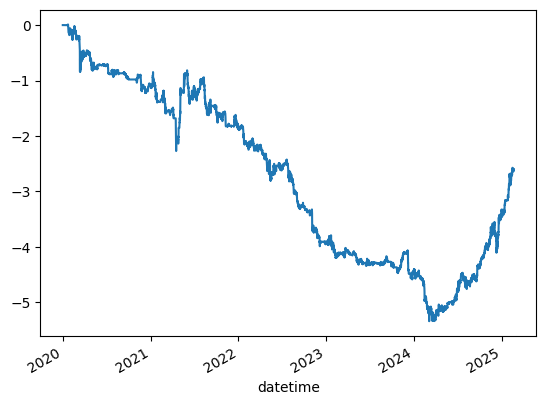

In [48]:
net_returns_ser.cumsum().plot()

Read data from existing file.

In [58]:
outcome_df = pd.read_csv("./strat_triples_trading_price_indicator_results.csv",
                         index_col=["z-score", "corr thresholds", "corr selection method"])

Transform existing data into dictionary.

In [59]:
raw_outcome_data = {"total sr": [], "in-sample sr": [], "out-sample sr": []}
indices = []

for (df_index, df_val) in outcome_df.iterrows():
    dict_index = (tuple(map(float, df_index[0][1:-1].split(','))),
                  tuple(map(float, df_index[1][1:-1].split(','))),
                  df_index[2])
    
    indices.append(dict_index)
    raw_outcome_data["total sr"].append(df_val["total sr"])
    raw_outcome_data["in-sample sr"].append(df_val["in-sample sr"])
    raw_outcome_data["out-sample sr"].append(df_val["out-sample sr"])

raw_outcome_data

{'total sr': [-0.6459260779267941],
 'in-sample sr': [-1.6229778432776298],
 'out-sample sr': [0.8496431824654427]}

Add sharpe-ratio data from new case to existing in-memory data.

In [54]:
tuple_index = (selection_conditions[selection_index][0],
               selection_conditions[selection_index][1],
               selection_conditions[selection_index][2])

raw_outcome_data["total sr"].append(sharpe_ratio_ser["total sr"])
raw_outcome_data["in-sample sr"].append(sharpe_ratio_ser["in-sample sr"])
raw_outcome_data["out-sample sr"].append(sharpe_ratio_ser["out-sample sr"])
indices.append(tuple_index)

outcome_df = pd.DataFrame(
    raw_outcome_data,
    index=pd.MultiIndex.from_tuples(indices, names=["z-score", "corr thresholds", "corr selection method"])
)
# outcome_df.index.set_names(["z-score", "corr thresholds", "corr selection method"], inplace=True)
outcome_df

,,,total sr,in-sample sr,out-sample sr
z-score,corr thresholds,corr selection method,,,
"(1.0, 10.0)","(0.9, 0.8)",CorrSelectionMethod.MAX_CORR,-0.645926,-1.622978,0.849643


In [57]:
outcome_df.to_csv("./strat_triples_trading_price_indicator_results.csv")

# Evaluate Different Sets Of Parameters With Log Prices As Indicators